In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
import traceback
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk

2024-10-21 20:11:15.339242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 20:11:16.119264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-21 20:11:16.119313: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-21 20:11:42.766766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, LeakyReLU, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  0


2024-10-21 20:13:14.315750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-10-21 20:13:14.315859: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-21 20:13:14.315912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sdfiana007): /proc/driver/nvidia/version does not exist


In [4]:
home_path = "/fs/ddn/sdf/group/atlas/d/lizhx/"
file_path = home_path + "preprocessed_SNL_data.h5"
with h5py.File(file_path, 'r') as hf:
    X_train = hf['X_train'][:]
    X_test  = hf['X_test'][:]
    Ato4l_data  = hf['Ato4l_data'][:]
    hToTauTau_data  = hf['hToTauTau_data'][:]
    hChToTauNu_data  = hf['hChToTauNu_data'][:]
    leptoquark_data = hf['leptoquark_data'][:]
    print("Data loaded from preprocessed_SNL_data.h5")


Data loaded from preprocessed_SNL_data.h5


In [5]:
# import argparse
# import h5py
# from sklearn.model_selection import train_test_split
# import numpy as np

# def create_datasets_dense(bkg_file, output_bkg_name, signals_files, output_signal_names, events=None, test_size=0.2, val_size=0.2, input_shape=57):
    
#     # read BACKGROUND data
#     with h5py.File(bkg_file, 'r') as file:
#         full_data = file['Particles'][:,:,:-1]
#         np.random.shuffle(full_data)
#         if events: full_data = full_data[:events,:,:]
    
#     # define training, test and validation datasets
#     X_train, X_test = train_test_split(full_data, test_size=test_size, shuffle=True)
#     X_train, X_val = train_test_split(X_train, test_size=val_size)

#     del full_data
    
#     # flatten the data for model input
#     X_train = X_train.reshape(X_train.shape[0], input_shape)
#     X_test = X_test.reshape(X_test.shape[0], input_shape)
#     X_val = X_val.reshape(X_val.shape[0], input_shape)
    
#     with h5py.File(output_bkg_name + '_dataset.h5', 'w') as h5f:
#         h5f.create_dataset('X_train', data = X_train)
#         h5f.create_dataset('X_test', data = X_test)
#         h5f.create_dataset('X_val', data = X_val)
    
#     if signals_files:
#         # read SIGNAL data
#         for i, signal_file in enumerate(signals_files):
#             f = h5py.File(signal_file,'r')
#             signal_data = f['Particles'][:,:,:-1]
#             signal_data = signal_data.reshape(signal_data.shape[0],input_shape)
#             with h5py.File(output_signal_names[i] + '_dataset.h5', 'w') as h5f2:
#                 h5f2.create_dataset('Data', data = signal_data)        
#     return

# bkg_file = "/eos/user/h/hjia/AnomalyDetection/40MHZ_data/background_for_training.h5"
# output_bkg_name = "SM_ZeroBias"

# create_datasets_dense(bkg_file, output_bkg_name, signals_files, output_signal_names)

In [6]:
# filename = "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/SM_ZeroBias_dataset.h5"
# with h5py.File(filename, 'r') as file:
#     X_train = np.array(file['X_train'])
#     X_test = np.array(file['X_test'])
#     X_val = np.array(file['X_val'])

In [7]:
# X_train = np.vstack((X_train, X_val))
# print(X_train.shape)

In [8]:
# def scale_columns(arr):
#     # Check if the input array has 57 columns
#     if arr.shape[1] != 57:
#         raise ValueError("Input array must have 57 columns")
    
#     # Create a copy of the input array to avoid modifying the original
#     scaled_arr = arr.copy()
# #     met_scale = 1
# #     em_scale = 1
# #     tau_scale = 1
# #     jet_scale = 1
# #     muon_scale = 1
#     met_scale = 512
#     em_scale = 128
#     tau_scale = 128
#     jet_scale = 256
#     muon_scale = 32
#     # Define the scaling factors for each column
#     scale_dict = {
#         0: 1/met_scale,
#         3: 1/em_scale, 6: 1/em_scale, 9: 1/em_scale, 12: 1/em_scale, 15: 1/tau_scale,
#         18: 1/tau_scale, 21: 1/tau_scale, 24: 1/tau_scale,
#         27: 1/jet_scale, 30: 1/jet_scale, 33: 1/jet_scale, 36: 1/jet_scale, 39: 1/jet_scale, 42: 1/jet_scale,
#         45: 1/muon_scale, 48: 1/muon_scale, 51: 1/muon_scale, 54: 1/muon_scale
#     }

#     # Apply scaling to the specified columns
#     for col, scale_factor in scale_dict.items():
#         scaled_arr[:, col] *= scale_factor
    
#     return scaled_arr
# X_train = scale_columns(X_train)
# X_test = scale_columns(X_test)

In [9]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [10]:
def analyze_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")

    for col in range(57):
        column = arr[:, col]
        
        # Calculate statistics
        mean_val = np.mean(column)
        min_val = np.min(column)
        max_val = np.max(column)
        has_nan = np.isnan(column).any()
        
        # Print results
        print(f"Column {col + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Contains NaN: {has_nan}")
        print()  # Empty line for readability
analyze_columns(X_train)

Column 1:
  Mean: -0.0000
  Min: -1.9571
  Max: 53.1526
  Contains NaN: False

Column 2:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 3:
  Mean: 0.0000
  Min: -1.7323
  Max: 1.7311
  Contains NaN: False

Column 4:
  Mean: -0.0000
  Min: -0.9537
  Max: 47.1318
  Contains NaN: False

Column 5:
  Mean: -0.0000
  Min: -2.4819
  Max: 2.4821
  Contains NaN: False

Column 6:
  Mean: -0.0000
  Min: -2.3496
  Max: 2.3489
  Contains NaN: False

Column 7:
  Mean: -0.0000
  Min: -0.0355
  Max: 200.8080
  Contains NaN: False

Column 8:
  Mean: -0.0000
  Min: -43.0203
  Max: 43.0213
  Contains NaN: False

Column 9:
  Mean: 0.0000
  Min: -34.6662
  Max: 34.6653
  Contains NaN: False

Column 10:
  Mean: 0.0000
  Min: -0.0108
  Max: 302.0646
  Contains NaN: False

Column 11:
  Mean: -0.0000
  Min: -181.6179
  Max: 181.7817
  Contains NaN: False

Column 12:
  Mean: -0.0000
  Min: -130.9459
  Max: 130.8367
  Contains NaN: False

Column 13:
  Mean: -0.0000
  Min: -0.0028
  Max:

In [12]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
#     x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense1")(inputs)
#     x = BatchNormalization(name="BN1")(x)
#     x = ReLU(name="relu1")(x)
    x = ReLU(name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense2")(x)    
#     x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z_logvar=Dense(latent_dim, name='z_log_var',
                          kernel_initializer=keras.initializers.Zeros(),
                          bias_initializer=keras.initializers.Zeros(),
                          kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_2,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x=layers.Dense(h_dim_1,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=layers.Dense(input_dim,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
#     jet_scale = 256/64
#     tau_scale = 128/64
#     muon_scale = 32/64
#     met_scale = 512/64
#     em_scale = 128/64
    jet_scale = 1
    tau_scale = 1
    muon_scale = 1
    met_scale = 1
    em_scale = 1
    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: met_scale,
        3: em_scale, 6: em_scale, 9: em_scale, 12: em_scale,
        15: tau_scale, 18: tau_scale, 21: tau_scale, 24: tau_scale,
        27: jet_scale, 30: jet_scale, 33: jet_scale, 36: jet_scale, 39: jet_scale, 42: jet_scale,
        45: muon_scale, 48: muon_scale, 51: muon_scale, 54: muon_scale
    }

    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    for index, factor in scale_dict.items():
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        scale_tensor += index_mask * (factor - 1)

    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor

    # Hardcoded lists for eta and phi indices
    eta_indices = [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
    phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56]

    batch_size = tf.shape(scaled_reconstruction)[0]
    
    # Set only the first eta (index 1) to zero
    indices = tf.stack([tf.range(batch_size), tf.ones(batch_size, dtype=tf.int32)], axis=1)
    updates = tf.zeros(batch_size)
    scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
    # Apply constraints to eta
    for i in eta_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
    # Apply constraints to phi
    for i in phi_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3.14159265258979 * tf.tanh(scaled_reconstruction[:, i] / 3.14159265258979)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
        
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)

    # Take the sum across all dimensions
    return tf.reduce_mean(mse)

class VAE_Model(keras.Model):
    def __init__(self, encoder, decoder, steps_per_epoch=3125, cycle_length=10, min_beta=0.1, max_beta=0.85, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta_tracker = keras.metrics.Mean(name="beta")
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.beta_tracker,
        ]

    def cyclical_annealing_beta(self, epoch):
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        return self.min_beta + (self.max_beta - self.min_beta) * tf.minimum(x, 1.0)
#     def set_beta(self,beta):
#         self.beta=beta

    def train_step(self, data):
        # Get the current epoch number
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        
        # Update beta
        self.beta.assign(self.cyclical_annealing_beta(epoch))
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mask = K.cast(K.not_equal(data, 0), K.floatx())
#             reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta

            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
#         reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "beta": self.beta,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        } 

In [13]:
def weighted_mse(y_true, y_pred, sample_weight):
    return tf.reduce_mean(tf.multiply(sample_weight, tf.square(y_true - y_pred)))

In [14]:
NUM_EPOCHS = 100
BATCH_SIZE = 16384
STOP_PATIENCE = 15
LR_PATIENCE = 10

In [15]:
#TOPO 2A Trainer

T2A_enc = Qmake_encoder_set_weights(X_train.shape[1],32,16,3)
T2A_dec = Qmake_decoder_set_weights(X_train.shape[1],32,16,3)
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.8)
# T2A.set_beta(beta)
opt = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1000)
T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]
# T2A.build(input_shape=(997315, 110))
T2A_enc.summary()
T2A_dec.summary()


2024-10-21 20:14:56.125588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 dense1 (Dense)                 (None, 32)           1856        ['input_1[0][0]']                
                                                                                                  
 relu1 (ReLU)                   (None, 32)           0           ['dense1[0][0]']                 
                                                                                                  
 dense2 (Dense)                 (None, 16)           528         ['relu1[0][0]']                  
                                                                                            

In [18]:


early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]


tf.keras.backend.clear_session()
history = T2A.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
# T2A.save_weights(filepath=home_path+'software_dev/trained_models/toyVAE/', save_format='tf')

Epoch 1/100
157/157 [==============================] - 46s 284ms/step - loss: 3.7314 - reco_loss: 3.6330 - kl_loss: 0.0912 - beta: 0.1564 - val_loss: 2.4945 - val_reco_loss: 2.3507 - val_kl_loss: 0.1438 - val_beta: 0.1564 - lr: 1.0000e-04
Epoch 2/100
157/157 [==============================] - 41s 262ms/step - loss: 2.0728 - reco_loss: 1.9937 - kl_loss: 0.0803 - beta: 0.2128 - val_loss: 1.7629 - val_reco_loss: 1.6291 - val_kl_loss: 0.1339 - val_beta: 0.2128 - lr: 1.0000e-04
Epoch 3/100
157/157 [==============================] - 41s 261ms/step - loss: 1.4655 - reco_loss: 1.3856 - kl_loss: 0.0836 - beta: 0.2691 - val_loss: 1.4078 - val_reco_loss: 1.2711 - val_kl_loss: 0.1367 - val_beta: 0.2691 - lr: 1.0000e-04
Epoch 4/100
157/157 [==============================] - 41s 259ms/step - loss: 1.1726 - reco_loss: 1.0857 - kl_loss: 0.0916 - beta: 0.3255 - val_loss: 1.1921 - val_reco_loss: 1.0444 - val_kl_loss: 0.1477 - val_beta: 0.3255 - lr: 1.0000e-04
Epoch 5/100
157/157 [=======================

In [10]:
for i in range(0,8):
    T2A_enc = Qmake_encoder_set_weights(X_train.shape[1],32,16,3)
    T2A_dec = Qmake_decoder_set_weights(X_train.shape[1],32,16,3)
    steps_per_epoch = X_train.shape[0] // BATCH_SIZE
    T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.8)
    # T2A.set_beta(beta)
    opt = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1000)
    T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]

    early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

    callbacks = [early_stopping, reduce_lr]

    tf.keras.backend.clear_session()
    history = T2A.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
    T2A.save_weights(filepath=home_path+f'software_dev/trained_models/gamma_tuning/VAE_only/iter_{i}/')

2024-10-10 22:29:33.900447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
157/157 [==============================] - 52s 276ms/step - loss: 36142.9862 - reco_loss: 36142.9319 - kl_loss: 0.0636 - beta: 0.1570 - val_loss: 964.7200 - val_reco_loss: 964.5878 - val_kl_loss: 0.1322 - val_beta: 0.1570 - lr: 0.0010
Epoch 2/100
157/157 [==============================] - 40s 255ms/step - loss: 11895.5652 - reco_loss: 11895.3575 - kl_loss: 0.2887 - beta: 0.2134 - val_loss: 800.5840 - val_reco_loss: 799.9629 - val_kl_loss: 0.6211 - val_beta: 0.2134 - lr: 0.0010
Epoch 3/100
157/157 [==============================] - 41s 259ms/step - loss: 9810.5764 - reco_loss: 9809.9089 - kl_loss: 0.8552 - beta: 0.2697 - val_loss: 668.8055 - val_reco_loss: 667.2033 - val_kl_loss: 1.6023 - val_beta: 0.2697 - lr: 0.0010
Epoch 4/100
157/157 [==============================] - 40s 256ms/step - loss: 9341.6965 - reco_loss: 9340.3303 - kl_loss: 1.5515 - beta: 0.3261 - val_loss: 577.5267 - val_reco_loss: 574.7037 - val_kl_loss: 2.8231 - val_beta: 0.3261 - lr: 0.0010
Epoch 5/100
157/

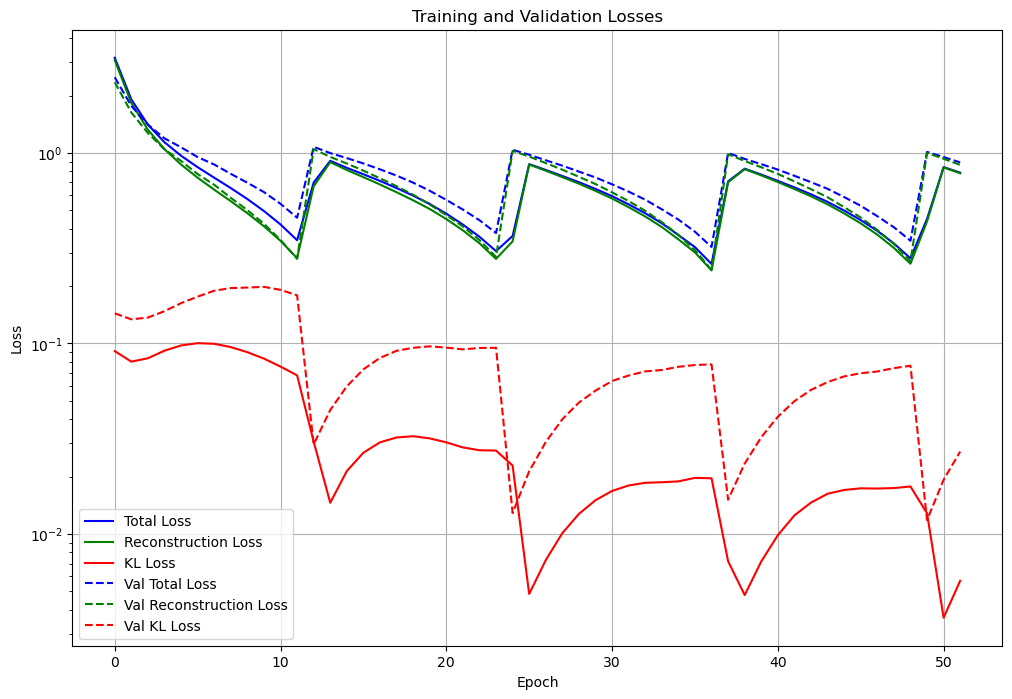

In [19]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by your model.fit() call

# Extract the loss values
total_loss = history.history['loss']
reco_loss = history.history['reco_loss']
kl_loss = history.history['kl_loss']
val_total_loss = history.history['val_loss']
val_reco_loss = history.history['val_reco_loss']
val_kl_loss = history.history['val_kl_loss']

# Create a new figure
plt.figure(figsize=(12, 8))

# Plot training losses
plt.plot(total_loss, label='Total Loss', color='blue')
plt.plot(reco_loss, label='Reconstruction Loss', color='green')
plt.plot(kl_loss, label='KL Loss', color='red')

# Plot validation losses
plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

# Customize the plot
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [25]:
# signals_file = ["/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/Ato4l_dataset.h5",
#                 "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/hToTauTau_dataset.h5",
#                 "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/hChToTauNu_dataset.h5",
#                 "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/leptoquark_dataset.h5"]
signal_labels = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"]

In [26]:
signal_data = []
# for i, label in enumerate(signal_labels):
#     with h5py.File(signals_file[i], 'r') as file:
#         test_data = np.array(scaler.transform(file['Data']))
# #         test_data = scale_columns(np.array(file['Data']))
#         signal_data.append(test_data)

In [20]:
def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    return kl_loss

def AD_score_CKL(z_mean, z_log_var):
    CKL = np.mean(z_mean**2)
    return CKL

class Model_Evaluator:
    def __init__(
        self,
        model_path,
        background,
        br_weights,
        signal,
        signal_weights,
        input_dim,
        title="placeholder",
        save=False,
        labels=None,
    ):

        self.input_dim = input_dim
        vae_enc = Qmake_encoder_set_weights(input_dim, 32,16,3)
        vae_dec = Qmake_decoder_set_weights(input_dim, 32,16,3)
        self.model = VAE_Model(vae_enc, vae_dec)
        self.model.load_weights(model_path)
        self.encoder = self.model.get_layer("encoder")
        self.signal = signal
        self.background = background
        self.br_loss = []
        self.signal_loss = []
        self.background_outputs = []
        self.signal_outputs = []
        self.title = title
        self.saveplots = save
        self.labels = labels
        self.latent_info = []
        self.br_weights = br_weights
        self.signal_weights = signal_weights

    def calculate_loss(self, l_type):
        self.signal_loss = []
        self.br_loss = []
        br = self.background

        if l_type == "CKL":
            br_latent = np.array(self.encoder.predict(br))
            self.latent_info += [br_latent[0]]
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_CKL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))
                self.latent_info += [sg_latent[0]]
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_CKL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        if l_type == "KL":
            br_latent = np.array(self.encoder.predict(br))
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_KL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))

                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_KL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]        

    def ROC(self):
        target_fpr = 1e-5
        tpr_at_target = []
        thresholds_at_target = []

        plt.plot(
            np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal"
        )
        for j, batch in enumerate(self.signal_loss):
            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr, label=self.labels[j] + ": " + str(round(auc, 3)))
            
            idx = np.argmin(np.abs(fpr - target_fpr))
            tpr_at_target.append(tpr[idx])
            thresholds_at_target.append(thresholds[idx])


        plt.xlabel("fpr")
        plt.xlim(1e-7, 1)
        plt.ylim(1e-7, 1)
        plt.semilogx()
        plt.ylabel("tpr")
        plt.semilogy()
        plt.title("{}_ROC".format(self.title))
        plt.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots == True:
            plt.savefig(
                "/fs/ddn/sdf/group/atlas/d/hjia625/ToyVAE/software_dev/plots/small/{}_ROC.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()
        
        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        for label, tpr, threshold in zip(self.labels, tpr_at_target, thresholds_at_target):
            print(f"{label}: {tpr*100:.6f}%, Theshold = {threshold:.6f}")

    def GetPerformance(self):
        target_fpr = 1e-5
        tpr_at_target = []

        print(f"Number of signal losses: {len(self.signal_loss)}")
        print(f"Number of labels: {len(self.labels)}")
        print(f"Number of signal weights: {len(self.signal_weights)}")
        print(f"Length of br_loss: {len(self.br_loss)}")

        plt.figure(figsize=(10, 6))
        plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal")

        for j, batch in enumerate(self.signal_loss):
            print(f"Processing batch {j}")
            print(f"Batch length: {len(batch)}")
            print(f"Signal weight length: {len(self.signal_weights[j])}")

            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = np.concatenate([np.zeros(len(self.br_loss)), np.ones(len(batch))])
            ROC_data = np.concatenate((self.br_loss, batch))

            print(f"ROC_data shape: {ROC_data.shape}")
            print(f"truth shape: {truth.shape}")
            print(f"weights shape: {weights.shape}")

            try:
                fpr, tpr, _ = sk.roc_curve(truth, ROC_data, sample_weight=weights)
                auc = sk.roc_auc_score(truth, ROC_data)

                plt.plot(fpr, tpr, label=f"{self.labels[j]}: {auc:.3f}")

                idx = np.argmin(np.abs(fpr - target_fpr))
                tpr_at_target.append(tpr[idx])

                print(f"Successfully processed batch {j}")
            except Exception as e:
                print(f"Error processing batch {j}: {str(e)}")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f"{self.title} ROC")
        plt.vlines(target_fpr, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots:
            plt.savefig(
                f"/fs/ddn/sdf/group/atlas/d/hjia625/ToyVAE/software_dev/plots/small/{self.title}_ROC.png",
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        results = list(zip(self.labels, tpr_at_target))
        for label, tpr in results:
            print(f"{label}: {tpr*100:.6f}%")

        print(f"Number of results: {len(results)}")
        return results


In [19]:
# def read_h5_data(file_path):
#     try:
#         with h5py.File(file_path, 'r') as f:
#             data = scaler.transform(f['Data'])
# #             data = scale_columns(np.array(f['Data']))
#         return data
#     except Exception as e:
#         print(f"Error reading file {file_path}: {str(e)}")
#         return None
# Ato4l_data = read_h5_data(signals_file[0])
# hToTauTau_data = read_h5_data(signals_file[1])
# hChToTauNu_data = read_h5_data(signals_file[2])
# leptoquark_data = read_h5_data(signals_file[3])

In [31]:
results = []
signal_names = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"]
channel_results = {}
# for i in range(20):
try:
    model_path = home_path+'software_dev/trained_models/toyVAE/'
    print(f"Evaluating model from path: {model_path}")
    evaluation = Model_Evaluator(model_path,
                            X_test,
                            np.ones(len(X_test)),
                            signal_data,
                            [np.ones(len(Ato4l_data)),
                                np.ones(len(hToTauTau_data)),
                                np.ones(len(hChToTauNu_data)),
                                np.ones(len(leptoquark_data))],
                            input_dim = X_test.shape[1],
                            title='VAE Model',
                            save = False,
                            labels = signal_labels)
    
    print("Model_Evaluator instance created successfully")
    
    print("Calculating losses...")
    evaluation.calculate_loss('KL')
    print("Losses calculated")
    
    print("Getting performance...")
    result = evaluation.GetPerformance()
    print(f"GetPerformance() returned: {result}")
    
    if not result:
        print(f"Warning: GetPerformance() returned an empty result for model {i}")
    else:
        for channel, tpr in result:
            if channel not in channel_results:
                channel_results[channel] = []
            channel_results[channel].append(tpr)

except Exception as e:
    print(f"An error occurred while evaluating model {i}:")
    print(traceback.format_exc())

print("Final channel results:", channel_results)

Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/toyVAE/
An error occurred while evaluating model 0:
Traceback (most recent call last):
  File "/lscratch/lizhx/tmp/ipykernel_1133013/288707360.py", line 11, in <module>
    evaluation = Model_Evaluator(model_path,
  File "/lscratch/lizhx/tmp/ipykernel_1133013/998634364.py", line 26, in __init__
    self.model = VAE_Model(vae_enc, vae_dec)
TypeError: __init__() missing 1 required positional argument: 'steps_per_epoch'

Final channel results: {}


In [ ]:
if channel_results:
    plt.figure(figsize=(12, 6))
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    x = np.arange(n_models)
    width = 0.8 / n_channels
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.bar(x + i * width, tprs, width, label=channel)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(x + width * (n_channels - 1) / 2, [f'Model {i}' for i in range(n_models)])
    plt.legend()
    plt.tight_layout()
    plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean*100:.4f}%, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

In [ ]:
if channel_results:
    plt.figure(figsize=(14, 8))  # Increased figure size to accommodate the legend
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.scatter(range(n_models), tprs, label=channel, s=50)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.semilogy()
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(range(n_models), [f'{i}' for i in range(n_models)])
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Place legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

10642/10642 [==============================] - 19s 2ms/step


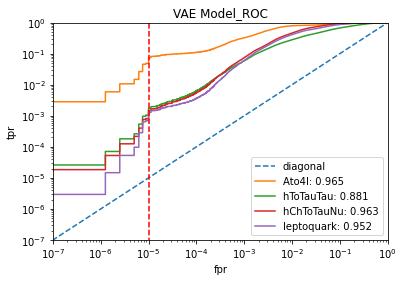


TPR at FPR = 1e-05 for each channel:
Ato4l: 4.840179%, Theshold = 177382.706232
hToTauTau: 0.104733%, Theshold = 177382.706232
hChToTauNu: 0.080761%, Theshold = 177382.706232
leptoquark: 0.069888%, Theshold = 177382.706232


In [21]:
Losses=['MSE']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/version1/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

10642/10642 [==============================] - 18s 2ms/step


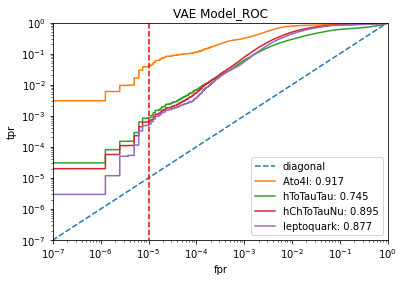


TPR at FPR = 1e-05 for each channel:
Ato4l: 3.791385%, Theshold = 34789.515625
hToTauTau: 0.083323%, Theshold = 34789.515625
hChToTauNu: 0.062741%, Theshold = 34789.515625
leptoquark: 0.049039%, Theshold = 34789.515625


In [22]:
Losses=['CKL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/version1/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

In [ ]:
Losses=['KL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/version1/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

In [18]:
print(Ato4l_data.shape)
print(hToTauTau_data.shape)
print(hChToTauNu_data.shape)
print(leptoquark_data.shape)

(55969, 57)
(691283, 57)
(760272, 57)
(340544, 57)


In [23]:
ori_vae_enc = Qmake_encoder_set_weights(57,32,16,3)
ori_vae_dec = Qmake_decoder_set_weights(57,32,16,3)
orginal_model = VAE_Model(ori_vae_enc, ori_vae_dec)
# orginal_model.predict(Ato4l_data)
orginal_model.load_weights("/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/version1/")


def make_simplified_encoder(input_dim, h_dim_1, h_dim_2, latent_dim):
    inputs = keras.Input(shape=(input_dim,), name='inputs')
#     x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             name = "dense1")(inputs)
#     x = BatchNormalization(name="BN1")(x)
    x = ReLU(name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             name = "dense2")(x)    
#     x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros())(x)
    new_encoder = keras.Model(inputs,z_mean,name='encoder')
    return new_encoder

In [24]:
new_encoder = make_simplified_encoder(57,32,16,3)
# Transfer weights from the original encoder
for layer in new_encoder.layers:
    original_layer = ori_vae_enc.get_layer(layer.name)
    if original_layer is not None:
        print("set weight for ", layer)
        print(original_layer.get_weights())
        layer.set_weights(original_layer.get_weights())

set weight for  <keras.src.engine.input_layer.InputLayer object at 0x7f406719ac40>
[]
set weight for  <keras.src.layers.core.dense.Dense object at 0x7f40671e1f70>
[array([[-0.02705688,  0.01632243, -0.01023644, ...,  0.01554523,
        -0.04189352,  0.02415809],
       [-0.15308043, -0.17816576, -0.05987004, ...,  0.41958103,
        -0.03714512,  0.11331005],
       [-0.02266147,  0.00731888, -0.01881623, ...,  0.06766188,
        -0.02835458, -0.0037509 ],
       ...,
       [-0.48511454, -0.3142542 , -0.20712487, ..., -0.22189808,
        -0.38092145, -0.21758635],
       [ 0.06738944,  0.11053742, -0.16982073, ..., -0.02774048,
        -0.00193155,  0.0117031 ],
       [ 0.08419731,  0.39925635, -0.11098306, ...,  0.04465427,
        -0.30307958, -0.07810986]], dtype=float32), array([ 0.04321184, -0.20232144,  0.18984695, -0.20244434,  0.45105204,
       -0.7102164 ,  0.09523638, -0.02751441,  0.54759014,  0.00984198,
       -0.3603616 , -0.558122  ,  0.5383631 ,  0.33886376,  0.1

In [27]:
tf.keras.models.save_model(new_encoder, 'VAE_40MHZ_model_Vsmall_onchip', save_format='tf')

INFO:tensorflow:Assets written to: VAE_40MHZ_model_Vsmall_onchip/assets


INFO:tensorflow:Assets written to: VAE_40MHZ_model_Vsmall_onchip/assets
